In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, brier_score_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)


# Load the data!

In [2]:
DATA_PATH = '../data/'

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    #pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    #pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    #pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)


In [3]:
tourney_results.shape

(1248, 34)

In [4]:
seeds.shape

(2490, 3)

In [5]:
regular_results.shape

(107634, 34)

In [6]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [7]:
regular_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,0.061308,26.299393,55.367851,6.695624,17.377166,16.500650,23.250217,11.580589,25.143847,15.278380,14.211872,7.622184,3.756282,17.880633,22.869584,56.866118,5.824090,18.720971,12.193674,18.055243,11.913345,21.115901,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,0.071319,25.928681,55.069350,6.708160,17.570335,16.405601,23.286371,11.608182,25.049880,15.137169,14.049880,7.742070,3.639029,17.798075,22.569241,56.301247,5.826515,18.825202,12.025159,18.057755,11.844235,21.224021,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,0.066524,25.975187,54.949305,6.769840,17.678503,15.973476,22.787594,11.565775,24.964920,15.184385,13.907380,7.699251,3.730053,17.403850,22.427594,56.047914,5.904385,18.922139,11.875722,17.767059,11.733690,21.038717,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,0.073996,25.920538,54.881228,6.845281,17.821526,15.901198,22.458272,11.591760,24.641581,15.141896,13.893000,7.616985,3.708430,17.253731,22.456801,55.836872,5.945133,18.882279,11.807862,17.589027,11.762035,20.874711,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,0.067618,25.896887,54.196907,7.043228,18.138608,15.992465,22.698989,11.222487,24.756098,15.043030,13.909974,7.179853,3.735277,17.443783,22.419790,55.712274,6.059092,19.453500,11.862978,17.645251,11.534404,20.671227,11.667460,15.218917,6.225858,2.760658,19.985524
2008,68.392020,1288.741817,74.962425,1281.907418,62.755375,0.072439,25.932597,54.543289,7.162309,18.386791,15.934922,22.575828,11.133256,25.101491,14.921557,13.720705,7.300213,3.777455,17.450126,22.392408,55.829556,6.165408,19.622119,11.805152,17.567306,11.340306,21.026148,11.578346,15.173155,6.171025,2.836529,19.803021
2009,70.963612,1287.680511,74.033721,1281.312250,61.980377,0.071633,25.724138,54.550200,6.749095,17.743189,15.836350,22.485616,11.178129,25.155839,14.568108,13.223852,7.161174,3.723757,17.297390,22.168223,55.771004,5.759954,18.787579,11.883978,17.740331,11.440846,21.195847,11.328062,14.696895,6.093161,2.777481,19.574776
2010,70.741212,1289.607638,74.652480,1279.997910,62.484325,0.063272,25.799734,54.756603,6.655330,17.520616,16.397682,23.306289,11.247767,25.550447,14.509215,13.117234,7.100513,3.989550,17.484515,22.180885,56.121414,5.690291,18.618659,12.432263,18.563177,11.568687,21.415162,11.194376,14.431693,6.137374,2.888087,19.872126
2011,70.881243,1285.244758,74.374190,1283.078727,62.470644,0.077964,25.600839,54.468547,6.733321,17.675562,16.439192,23.221883,11.132863,25.473504,14.476363,12.904117,6.787266,3.829966,17.581395,22.159360,55.676325,5.736561,18.551658,12.415364,18.471979,11.168319,21.326916,11.180518,14.131910,5.933283,2.961685,20.081395


In [8]:
tourney_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,139.156250,1283.343750,76.562500,1288.765625,65.546875,0.093750,27.703125,57.906250,6.640625,16.281250,14.515625,20.218750,11.781250,25.546875,14.765625,12.875000,7.015625,3.890625,17.453125,23.375000,58.906250,6.515625,19.968750,12.281250,17.796875,12.421875,21.171875,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.156250,1286.515625,75.500000,1300.640625,64.265625,0.046875,25.890625,54.531250,6.906250,17.500000,16.812500,23.296875,11.125000,25.875000,14.859375,12.546875,6.921875,3.625000,16.625000,23.140625,58.468750,6.203125,20.468750,11.781250,16.750000,11.734375,20.593750,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.156250,1306.031250,75.562500,1299.562500,65.375000,0.109375,26.281250,54.609375,6.953125,18.015625,16.046875,22.203125,10.609375,25.203125,15.093750,13.078125,7.031250,3.484375,17.000000,23.531250,58.546875,6.328125,19.734375,11.984375,17.234375,12.359375,20.984375,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.156250,1282.250000,73.203125,1291.500000,63.171875,0.109375,24.984375,54.093750,6.609375,18.015625,16.625000,22.640625,11.109375,24.718750,14.125000,11.906250,6.718750,4.250000,15.562500,22.984375,57.234375,6.171875,19.890625,11.031250,15.625000,11.859375,21.375000,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.156250,1320.593750,75.703125,1299.421875,63.578125,0.093750,25.515625,54.250000,7.421875,18.406250,17.250000,23.531250,11.531250,25.500000,13.921875,12.265625,6.156250,4.015625,16.796875,22.937500,57.390625,6.046875,19.984375,11.656250,16.875000,11.359375,20.406250,11.500000,12.468750,5.906250,2.843750,20.328125
2008,139.156250,1329.781250,77.218750,1292.046875,63.281250,0.093750,27.500000,55.453125,6.937500,17.375000,15.281250,21.265625,11.312500,26.546875,15.218750,12.718750,6.515625,4.062500,17.468750,22.375000,57.390625,6.250000,20.609375,12.281250,18.171875,11.578125,20.031250,10.890625,12.593750,6.171875,2.890625,19.093750
2009,139.156250,1300.187500,77.250000,1284.843750,64.343750,0.046875,27.062500,57.000000,6.453125,17.265625,16.671875,23.000000,11.812500,26.531250,15.546875,12.250000,6.796875,3.687500,16.453125,23.296875,59.328125,5.968750,20.250000,11.781250,16.953125,11.734375,21.109375,11.703125,12.593750,5.953125,3.234375,19.593750
2010,139.156250,1287.031250,74.031250,1313.937500,63.328125,0.109375,25.515625,55.218750,7.125000,18.609375,15.875000,22.015625,11.546875,25.359375,14.234375,11.750000,6.875000,4.109375,17.031250,22.687500,57.484375,5.937500,19.468750,12.015625,18.109375,12.062500,21.140625,11.421875,12.234375,6.140625,3.000000,19.125000
2011,138.955224,1270.089552,73.194030,1299.208955,61.910448,0.089552,25.537313,54.716418,7.179104,18.358209,14.940299,20.223881,10.716418,25.776119,14.895522,11.059701,5.805970,3.641791,15.865672,22.313433,56.567164,5.955224,19.805970,11.328358,16.089552,10.805970,21.492537,11.447761,11.656716,5.701493,2.820896,18.313433


In [9]:
seeds.tail()

,Season,Seed,TeamID
2485,2023,Z12,1433
2486,2023,Z13,1233
2487,2023,Z14,1213
2488,2023,Z15,1421
2489,2023,Z16,1224


In [10]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [11]:
all(regular_results.columns == tourney_results.columns)

True

# Data preparation!

In [12]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [13]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [14]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [15]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [16]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [17]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,location,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [18]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,location,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [19]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [20]:
regular_results.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
107629,2023,132,1104,82,1401,63,N,0,27,66,12,36,16,22,21,29,16,12,6,7,19,19,64,5,15,20,24,17,20,6,13,5,2,21
107630,2023,132,1272,75,1222,65,A,0,27,53,6,12,15,21,9,27,11,11,4,2,18,20,64,6,25,19,28,22,20,11,10,5,4,19
107631,2023,132,1343,74,1463,65,H,0,23,57,9,23,19,24,11,25,11,5,3,2,18,22,50,8,22,13,19,6,25,12,10,3,7,20
107632,2023,132,1345,67,1336,65,N,0,24,62,6,28,13,20,13,25,17,7,5,0,14,22,51,7,23,14,15,4,27,14,10,4,2,20
107633,2023,132,1433,68,1173,56,N,0,24,52,8,17,12,20,11,22,17,6,4,3,19,18,56,3,22,17,20,16,22,11,8,1,6,21


In [21]:
regular_results_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [22]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [23]:
regular_data.shape

(215268, 34)

In [24]:
"""
tourney_results = pd.read_csv('../input/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/WRegularSeasonDetailedResults.csv')
"""

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    #pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    #pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    #pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)


def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [25]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [26]:
regular_data.shape

(215268, 35)

In [27]:
tourney_data.shape

(2496, 35)

In [28]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [29]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


# Feature engineering!

In [30]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [31]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [32]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714   

                     T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       13.000000  11.428571  5.964286  18.750000  19.285714   
       1103       15.222222  12.629630  7.259259  19.851852  27.777778   
       1104       12.107143  13.285714  6.607143  18.035714  23.250000   
       1105       14.538462  18.653846  9.307692  20.230769  27.000000   
       1106       11.678571  17.035714  8.357143  18.178571  21.714286   

                     T2_FGA   T2_FGM3    T2_FGA3      T2_OR     T2_Ast  \
                       mean      mean       mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       42.428571  4.750000  12.428571   9.607143   9.142857   
       1103       57.000000  6.666667  18.370370  12.037037  15.481481   
       1104       55.500000  6.357143  19.142857  10.892857  11.678571   
       1105       58.961538  6.269231  17.538462  13.192308  15.807692   
       1106       53.392857  4.785714  15.214286  11.321429  11.785714   

                      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean      mean      mean      mean  
Season T1_TeamID                                           
2003   1102       12.964286  5.428571  1.571429  0.250000  
       1103       15.333333  6.407407  2.851852  0.629630  
       1104       13.857143  5.535714  3.178571  4.285714  
       1105       18.807692  9.384615  4.192308 -4.884615  
       1106       15.071429  8.785714  3.178571 -0.142857

In [33]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [34]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [35]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [36]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [37]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [38]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


In [39]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [40]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [41]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [42]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [43]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [44]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(11692, 5)

In [45]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [46]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()
quality.columns = ['TeamID','quality']
quality['Season'] = 2010
#quality['quality'] = np.exp(quality['quality'])
quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)

In [47]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

/Users/skylerdale/.virtualenvs/ncaa_model/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [48]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [49]:
glm_quality_T2.head()

,T2_TeamID,T2_quality,Season
0,1115,0.000003,2010
1,1124,27.016434,2010
2,1139,25.584504,2010
3,1140,25.617284,2010
4,1143,24.547899,2010


In [50]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [51]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN


In [52]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [53]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.tail()

,Season,Seed,TeamID,seed
2485,2023,Z12,1433,12
2486,2023,Z13,1233,13
2487,2023,Z14,1213,14
2488,2023,Z15,1421,15
2489,2023,Z16,1224,16


In [54]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [55]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [56]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# Time to build some models!

In [147]:
tourney_data = tourney_data[tourney_data.T1_TeamID < 3000].copy()

In [148]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2496.000000
mean        0.000000
std        14.411502
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
dtype: float64

In [57]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [150]:
tourney_data.shape

(2496, 51)

In [151]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [152]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [153]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [154]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[22:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings

In [155]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([85, 139, 123], [9.017845, 8.984, 9.0050908])

In [157]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
[22:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[22:38:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:38:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:38:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then bein

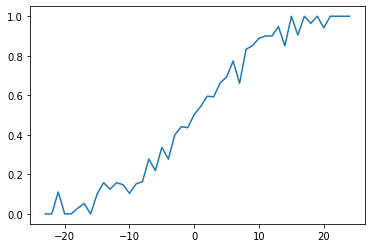

In [158]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [59]:
tourney_data["outcome"] = np.where(tourney_data['T1_Score'] > tourney_data['T2_Score'], 1, 0)

In [67]:
tourney_data[tourney_data["T2_PointDiffmean"].isna()]

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,outcome


In [70]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,outcome
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN,16,16,0,1
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN,1,16,-15,1
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN,10,7,3,1
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN,11,6,5,1
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN,8,9,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2022,146,1274,50,1242,76,27.575758,57.636364,7.303030,20.696970,6.242424,14.000000,9.303030,8.727273,14.939394,26.666667,57.303030,7.939394,22.545455,8.666667,15.090909,13.212121,5.333333,3.181818,3.787879,28.647059,59.558824,7.147059,20.117647,9.941176,15.441176,12.029412,6.411765,15.882353,25.088235,60.029412,6.176471,20.529412,8.970588,11.911765,12.088235,6.852941,3.088235,10.441176,0.750000,0.833333,22.315342,24.256566,10,1,9,0
2492,2022,146,1389,49,1314,69,23.206897,54.551724,5.758621,16.551724,9.068966,11.965517,13.137931,7.310345,19.620690,20.379310,52.620690,5.620690,19.103448,7.620690,10.517241,13.241379,7.068966,5.000000,3.931034,27.636364,61.030303,8.272727,22.848485,9.303030,14.818182,11.333333,5.393939,14.363636,26.939394,62.121212,8.000000,22.909091,6.242424,12.939394,9.666667,6.606061,3.242424,5.787879,1.000000,0.750000,-0.385350,22.212809,15,8,7,0
2493,2022,152,1437,6

In [82]:
from sklearn.preprocessing import StandardScaler
tourney_data[features] = StandardScaler().fit_transform(tourney_data[features])


In [95]:
features = []

array([1, 1, 1, ..., 0, 0, 0])

In [102]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=.01)
features = features[0:-2]

oof_preds_lr = []

X = tourney_data[features].values
y = tourney_data["outcome"].values

for i in range(3):
    print(f"Fold repeater {i}")
    preds = y.astype(float).copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X):

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train)

        #print(model.predict_proba(X_val)[:, 1])

        preds[val_index] = model.predict_proba(X_val)[:, 1]
        #print(preds)
    print(f"logloss of cvsplit {i}: {log_loss(y,preds)}") 
    print(f"brier score of cvsplit {i}: {brier_score_loss(y,preds)}") 
    oof_preds_lr.append(np.clip(preds,-30,30))


Fold repeater 0
logloss of cvsplit 0: 0.6783889851749105
brier score of cvsplit 0: 0.2427431341832147
Fold repeater 1
logloss of cvsplit 1: 0.6789350852269345
brier score of cvsplit 1: 0.2430010303105496
Fold repeater 2
logloss of cvsplit 2: 0.6783219979269324
brier score of cvsplit 2: 0.24271278258285342


In [99]:
oof_preds_lr[0].max()

0.7885738694626286

In [205]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    print(f"logloss of cvsplit {i}: {brier_score_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5563925105062146
logloss of cvsplit 0: 0.19065819415858146
logloss of cvsplit 1: 0.5535417154568663
logloss of cvsplit 1: 0.18930413511895536
logloss of cvsplit 2: 0.5558568282260877
logloss of cvsplit 2: 0.19020033828513433


/var/folders/2g/465yxy_x4g786jx2llr5xqh40000gn/T/ipykernel_19116/1482360335.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()


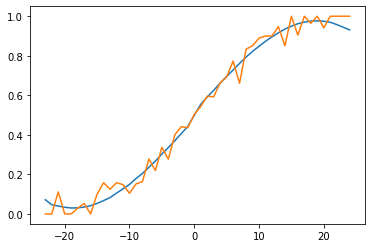

In [163]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [72]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5133922899704435
adjusted logloss of cvsplit 1: 0.5119533827697921
adjusted logloss of cvsplit 2: 0.5148108681813977


In [73]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.0392639068974054
adjusted logloss of cvsplit 1: 1.038559505205433
adjusted logloss of cvsplit 2: 1.0408107042595605


In [74]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
3022,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,1.000000,1.000000,1.229404e+15,-2.877398e+15,1,16,-15
2613,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,11.909091,12.454545,12.181818,6.242424,18.181818,25.515152,58.909091,4.454545,14.060606,11.696970,11.151515,12.909091,5.666667,2.666667,9.060606,25.750000,57.812500,7.406250,20.875000,10.843750,13.000000,11.531250,7.812500,17.781250,23.187500,55.562500,5.968750,17.906250,10.218750,13.062500,14.687500,5.687500,3.843750,10.218750,0.500000,1.000000,1.992558e+15,-2.310647e+15,2,15,-13
2616,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,9.176471,16.205882,10.294118,8.205882,14.117647,24.617647,55.794118,6.235294,17.205882,10.764706,12.823529,14.411765,5.264706,2.647059,14.558824,24.312500,54.281250,5.343750,17.031250,11.187500,12.000000,14.812500,6.531250,19.093750,23.375000,57.687500,5.625000,18.468750,12.281250,11.093750,13.656250,6.593750,3.125000,2.812500,1.000000,1.000000,2.639178e+15,-3.116482e+15,2,15,-13
2676,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,9.225806,14.806452,12.677419,7.548387,16.870968,19.419355,51.612903,5.354839,17.580645,10.806452,10.903226,14.225806,6.354839,3.290323,8.838710,26.218750,57.500000,6.625000,20.031250,11.687500,13.718750,14.656250,8.812500,17.593750,23.625000,57.468750,6.875000,21.843750,12.000000,13.281250,15.656250,6.937500,3.031250,5.031250,0.500000,1.000000,2.376682e+15,7.646472e+14,2,15,-13
2878,2016,137,1277,81,1292,90,28.794118,59.529412,9.117647,21.029412,12.294118,20.558824,11.794118,4.411765,19.088235,21.794118,57.823529,5.676471,18.794118,9.352941,10.617647,9.558824,5.323529,3.235294,16.382353,25.903226,57.709677,8.000000,20.580645,10.258065,13.032258,11.935484,6.258065,20.451613,23.225806,54.322581,6.258065,18.354839,9.064516,11.451613,13.516129,5.838710,2.774194,4.096774,1.000000,1.000000,-2.995853e+14,-1.764228e+15,2,15,-13
3135,2021,137,1326,72,1331,75,26.333333,57.300000,8.233333,22.566667,8.333333,13.033333,9.933333,4.600000,5.933333,24.733333,58.366667,7.566667,22.166667,8.133333,13.600000,9.900000,4.633333,2.700000,6.366667,27.260870,61.000000,10.869565,28.000000,6.565217,11.608696,11.173913,6.217391,8.000000,27.956522,62.565217,7.130435,20.043478,10.347826,12.391304,12.478261,5.565217,3.086957,1.826087,0.600000,1.000000,1.736001e+15,-9.300608e+14,2,15,-13
3206,2022,136,1246,79,1389,85,30.424242,62.787879,6.151515,17.606061,11.393939,16.090909,11.121212,6.818182,14.242424,24.424242,59.393939,6.484848,21.333333,7.515152,11.272727,11.606061,6.060606,2.909091,13.454545,23.206897,54.551724,5.758621,16.551724,9.068966,11.965517,13.137931,7.310345,19.620690,20.379310,52.620690,5.620690,19.103448,7.620690,10.517241,13.241379,7.068966,5.000000,3.931034,0.750000,1.000000,2.461175e+15,-4.087404e+13,2,15,-13
2153,2005,137,1242,63,1137,64,26.931034,56.482759,6.793103,18.206897,11.793103,16.586207,14.482759,6.620690,19.241379,22.10344

In [75]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.488851503913326
adjusted logloss of cvsplit 1: 0.48825614011378304
adjusted logloss of cvsplit 2: 0.4901508705861498


In [76]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.488851503913326
adjusted logloss of cvsplit 1: 0.48825614011378304
adjusted logloss of cvsplit 2: 0.4901508705861498


season
2003    0.517868
2004    0.483807
2005    0.485029
2006    0.545736
2007    0.423498
2008    0.459330
2009    0.460761
2010    0.468171
2011    0.481845
2012    0.488071
2013    0.490075
2014    0.490259
2015    0.423251
2016    0.536861
2017    0.478090
2018    0.533064
2019    0.433535
2021    0.531968
2022    0.535677
dtype: float64

# Submission time!

In [77]:
"""
sub["Season"] = 2018
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()
"""
sub = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


In [78]:
seeds_T1.tail()

,Season,T1_TeamID,T1_seed
4093,2023,3405,12
4094,2023,3387,13
4095,2023,3241,14
4096,2023,3436,15
4097,2023,3151,16


In [79]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,23.625000,51.125000,8.156250,22.906250,5.625000,15.312500,10.906250,5.750000,17.000000,23.875000,53.687500,5.187500,17.687500,7.937500,10.093750,10.687500,5.718750,3.093750,-0.125000,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,2023_1101_1103,0.5,2023,1101,1103,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,25.387097,57.451613,8.806452,25.193548,8.387097,13.000000,10.838710,5.774194,16.193548,24.709677,56.806452,7.064516,20.096774,7.322581,11.483871,11.322581,5.709677,3.032258,5.838710,NaN,NaN,NaN,NaN,0.0,0.5,NaN
2,2023_1101_1104,0.5,2023,1101,1104,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,27.764706,62.205882,10.058824,29.764706,11.264706,15.205882,13.588235,6.058824,18.617647,23.941176,64.382353,5.529412,19.705882,9.500000,10.000000,11.411765,7.294118,3.705882,13.676471,NaN,2.745259e+14,NaN,1.0,0.0,0.8,NaN
3,2023_1101_1105,0.5,2023,1101,1105,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,24.233333,56.500000,6.400000,18.466667,8.766667,12.066667,13.733333,7.500000,19.100000,23.600000,55.300000,7.466667,22.066667,9.966667,12.600000,14.166667,7.500000,3.700000,-3.066667,NaN,NaN,NaN,NaN,0.0,0.5,NaN
4,2023_1101_1106,0.5,2023,1101,1106,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,21.800000,58.566667,5.966667,19.400000,10.300000,9.733333,12.300000,5.666667,17.866667,25.733333,58.800000,6.966667,20.400000,10.633333,11.833333,11.266667,6.733333,4.833333,-10.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [80]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [81]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2


In [82]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [83]:
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2023_1101_1102,0.817713,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,23.625000,51.125000,8.156250,22.906250,5.625000,15.312500,10.906250,5.750000,17.000000,23.875000,53.687500,5.187500,17.687500,7.937500,10.093750,10.687500,5.718750,3.093750,-0.125000,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,2023_1101_1103,0.799821,2023,1101,1103,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,25.387097,57.451613,8.806452,25.193548,8.387097,13.000000,10.838710,5.774194,16.193548,24.709677,56.806452,7.064516,20.096774,7.322581,11.483871,11.322581,5.709677,3.032258,5.838710,NaN,NaN,NaN,NaN,0.0,0.5,NaN
2,2023_1101_1104,0.760076,2023,1101,1104,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,27.764706,62.205882,10.058824,29.764706,11.264706,15.205882,13.588235,6.058824,18.617647,23.941176,64.382353,5.529412,19.705882,9.500000,10.000000,11.411765,7.294118,3.705882,13.676471,NaN,2.745259e+14,NaN,1.0,0.0,0.8,NaN
3,2023_1101_1105,0.808418,2023,1101,1105,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,24.233333,56.500000,6.400000,18.466667,8.766667,12.066667,13.733333,7.500000,19.100000,23.600000,55.300000,7.466667,22.066667,9.966667,12.600000,14.166667,7.500000,3.700000,-3.066667,NaN,NaN,NaN,NaN,0.0,0.5,NaN
4,2023_1101_1106,0.835304,2023,1101,1106,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,21.800000,58.566667,5.966667,19.400000,10.300000,9.733333,12.300000,5.666667,17.866667,25.733333,58.800000,6.966667,20.400000,10.633333,11.833333,11.266667,6.733333,4.833333,-10.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [84]:
"""
tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
tourney_results2018.columns = ['ID', 'label']
tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
log_loss(tourney_results2018.label, tourney_results2018.Pred)
"""

"\ntourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')\ntourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)\ntourney_results2018.columns = ['ID', 'label']\ntourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')\nlog_loss(tourney_results2018.label, tourney_results2018.Pred)\n"